# Perturb-based vs. SHAP-based attributions

## Experiments
Here we explore SMILES-based attributions calculated with the Substitution (CDDD), and atom-based attributions calculated with SHAP (Morgan), and _Riniker and Landrum_ method (Morgan).

LogP per atom is used to create a reference set of attributions that we can compare with attributions from XAI methods calculated with different models.


### How to run this notebook

Note that you need **JupyterLab** to see the visualization - it may not work in other environments

You can run All cells and it will load the models and molecules, and then display the visualizations.

By default, the cells with the heavier parts (model training, etc.) have a flag set to False, so they are ignored and uses pre-computed data.


## References

CDDD: https://github.com/jrwnter/cddd

250 mol dataset: https://github.com/jensengroup/FP_RF_XAI

## Citation

If you use this use case, Substitution method, attributions, or visualizations, please cite XSMILES (URL TBD) and xBCF (URL TBD).

### Initial Setup

In [128]:
%%capture

# Pre-trained CatBoost models
logp_model_path = "../data/logp_model.joblib"
logp_model_path_morgan = "../data/logp_morgan_model.joblib"


# saves the embeddings calculated with CDDD
data_w_cddd_emb_path = "../data/emb.npz"

# general imports
import numpy as np
np.random.rand(56234)

import pandas as pd
import sklearn

# access to /src code
import sys
sys.path.append("../src/")

import random
random.seed(56234)

from cddd.inference import InferenceModel
from cddd.preprocessing import preprocess_smiles
from chem_util import smiles_to_mols
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors



def standardize_smiles_list(smiles_list):
    return [preprocess_smiles(s) for s in smiles_list]

def preprocess(df):
    n_smiles = len(df.smiles.values.tolist())
    smiles_list = df.smiles.values.tolist()
    mols, successful_inds = smiles_to_mols(smiles_list)
    df['logp'] = [Descriptors.MolLogP(i) for i in mols]
    df['smiles'] = standardize_smiles_list(df.smiles.values.tolist())
    df = df.dropna()
    df['smiles'] = df['smiles'].astype(str)    
    print("Ignored molecules due to problematic smiles or null logp/charges:", n_smiles-len(df.smiles.tolist()))
    df = df.reset_index()
    return df


In [129]:
%%capture
# load CDDD default model
# This package is not official. We compiled the original project in a way 
# that the python code and model are combined into one package, 
# so you don't need to worry about copying folders here and there.
from cddd.inference import InferenceModel
cddd_model = InferenceModel(use_gpu=False, cpu_threads=4)

## Prepare training data
1. Load the source data to get the SMILES and target values
2. Add LogP, Max LogP and Min LogP columns to the data frame.
3. Load the CDDD model and generate embeddings to npz file. (save as file to save time for future runs)


In [130]:
# SET to True if you want to preprocess again - the data was already stored in other format after preprocessing the original
prepare_data = False

small_data_test = False # Set to true to run a quick test (sample 2% data from the entire set)

df = None
if prepare_data:
    # ZINC_250k.smi original data from: https://github.com/jensengroup/FP_RF_XAI 
    # Unzip from our data/ZINC_250K.smi.zip
    df = pd.read_csv("../data/ZINC_250k.smi")
    if small_data_test:
        df = df = df.sample(frac=0.02).reset_index(drop=True)
    
    df = preprocess(df)    

    if small_data_test:
        df.to_csv('../data/test_mols_logp.csv') 
    else:
        df.to_csv('../data/250k_mols_logp.csv')  
       
    print(len(df))
    df.head()
else:
    if small_data_test:
        df = pd.read_csv("../data/test_mols_logp.csv")
    else:
        df = pd.read_csv("../data/250k_mols_logp.csv") 
df.head()



,Unnamed: 0,index,smiles,logp
0,0,0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060
1,1,1,CC1CC(C)CC(Nc2cncc(-c3nncn3C)c2)C1,3.11370
2,2,2,N#Cc1ccc(-c2ccc(OC(C(=O)N3CCCC3)c3ccccc3)cc2)cc1,4.96778
3,3,3,CCOC(=O)C1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c2CCCC...,4.00022
4,4,4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])C(C#N)C1...,3.60956


In [131]:
smiles_list = df.smiles.values.tolist()
ids = range(len(smiles_list)) #df.iupac.values.tolist()

logp = df.logp.values.tolist()

print(len(smiles_list))

data_size = len(ids)
perm_idx = np.random.permutation(data_size)
train_idx = perm_idx[:int(0.8*data_size)] 
test_idx = perm_idx[int(0.8*data_size):] 

249437


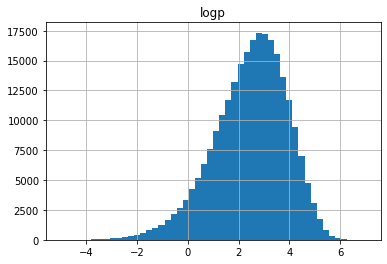

In [132]:
import matplotlib.pyplot as plt
plt.show(df.hist(column="logp", bins=50))

In [133]:
from chem_util import calc_morgan_counts_for_mol
from fp_xai.fp_xai import mol2fp
from rdkit import Chem
def calc_morgan_fingerprints(smiles_list):
    mols = [Chem.MolFromSmiles(smiles_string, sanitize=True) for smiles_string in smiles_list]
    #featuresMorganCounts = [calc_morgan_counts_for_mol(mol, radius=1, nBits=2048) for mol in mols]
    fingerprints = [mol2fp(mol, radius=1, n_bits=2048) for mol in mols]
    columns = ["fp_morgan_counts_" + str(i) for i in range(2048)]
    fingerprints = pd.DataFrame(fingerprints, columns=columns)
    return(fingerprints)


In [134]:
# Change to true if you don't have emb.npz in /data 
generate_cddd = False 

if generate_cddd:
    print("Calculating CDDD Embeddings and Morgan Fingerprints...")
    embeddings = cddd_model.seq_to_emb(smiles_list)
    
    morgan_fingerprints = calc_morgan_fingerprints(smiles_list)
    
    np.savez_compressed(
        data_w_cddd_emb_path,
        bid=ids,
        smiles=smiles_list,
        embeddings=embeddings,
        morgan_fingerprints=morgan_fingerprints,
        logp=logp,           
    )
    print("CDDD Embeddings and Morgan Fingerprints generated and saved successfully!")

## Training Models

1. Load the embedding file
2. Train-test split
3. Scale the target
4. Training
5. Testing
6. Train a final model on the entire dataset

In [135]:
# SET to True if you want to retrain models
train_models = False # if you want to train the models, please set generate_cddd=True, you need to generate the embeddings 

if train_models:
    all_data = np.load(data_w_cddd_emb_path, allow_pickle=True) # dataframe with embeddings


    smiles_list = all_data['smiles']
    embs = all_data['embeddings']
    morgan_fingerprints =  all_data['morgan_fingerprints']
    ids = all_data['bid']

    # logp
    logp = all_data['logp']


    data_size
    type(embs), embs.shape, type(logp), logp.shape, len(train_idx), len(test_idx)

In [136]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import joblib

def build_model(train_x, test_x, train_y, test_y, model, save_model_path, save=False):
    #wrapped_model = TransformedTargetRegressor(regressor=model, transformer=MinMaxScaler())
    wrapped_model = model
    wrapped_model.fit(train_x, train_y)
    
    model_name = save_model_path.replace("../data/","").replace("_model.joblib","")
    min_y = min([min(train_y), min(test_y)])
    max_y = max([max(train_y), max(test_y)])
    print(min_y, max_y)

    yhat = wrapped_model.predict(train_x)
    min_yh = min([min_y, min(yhat)])*1.2
    max_yh = max([max_y, max(yhat)])*1.2
    r2 = r2_score(train_y, yhat)    
    plt.scatter(yhat, train_y)
    plt.xlim(min_yh, max_yh)
    plt.ylim(min_yh, max_yh)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(model_name + " - Train (R2: "+str(r2)+")")    
    plt.show()

    if save:
        joblib.dump(wrapped_model, save_model_path)
    return wrapped_model

model = CatBoostRegressor(iterations=10000, depth=6, thread_count=-1, random_seed=4514134, silent=True)


In [137]:

def plot_test(yhat, test_y, model_name):
    min_y = min(test_y)
    max_y = max(test_y)
    print(min_y, max_y)
    min_yh = min([min_y, min(yhat)])*1.2
    max_yh = max([max_y, max(yhat)])*1.2
    r2 = r2_score(test_y, yhat)  
    rmse = mean_squared_error(test_y, yhat)
    plt.scatter(yhat, test_y)
    plt.xlim(min_yh, max_yh)
    plt.ylim(min_yh, max_yh)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(model_name + " - Test (R2: "+str(r2)+", RMSE: "+str(rmse)+")")
    plt.show()

def test_model(test_y, yhat, model_name):
    
    plot_test(yhat, test_y, model_name)



In [138]:
import joblib
from sklearn.base import clone

logpModelMorgan = None
logpModel = None
# RFmodel = None

# import pickle 
# if RFmodel == None:
#     RFmodel = pickle.load(open("../data/150000_200_3_2048.p", 'rb'))


if train_models:
    # MORGAN_FINGERPRINTS-based
    train_x_morgan, test_x_morgan = morgan_fingerprints[train_idx, :], morgan_fingerprints[test_idx, :]
    try:
        model = model.copy()
    except:
        model = clone(model)
    logpModelMorgan = build_model( train_x=train_x_morgan, 
                train_y=logp[train_idx], 
                test_x=test_x_morgan, 
                test_y=logp[test_idx], 
                model=model,
                save_model_path=logp_model_path_morgan,
                save=True
            )

    # #SMILES CDDD-based
    train_x, test_x = embs[train_idx, :], embs[test_idx, :]
    try:
        model = model.copy()
    except:
        model = clone(model)
    logpModel = build_model(train_x=train_x, 
                train_y=logp[train_idx], 
                test_x=test_x, 
                test_y=logp[test_idx], 
                model=model,
                save_model_path=logp_model_path,
                save=True
            )


In [139]:

test_saved_models = False # if you want to print graphics about testing results
    
# Morgan    
logpModelMorgan = joblib.load(logp_model_path_morgan)
if test_saved_models:    
    test_x_morgan = morgan_fingerprints[test_idx, :]
    model_name = logp_model_path_morgan.replace("../data/","").replace("_model.joblib","")
    yhat = logpModelMorgan.predict(test_x_morgan)
    test_model(test_y=logp[test_idx], yhat=yhat, model_name=model_name) #test_y, yhat, model_name

# CDDD
logpModel = joblib.load(logp_model_path)  
if test_saved_models:    
    test_x = embs[test_idx, :]
    model_name = logp_model_path.replace("../data/","").replace("_model.joblib","")
    yhat = logpModel.predict(test_x)        
    test_model(test_y=logp[test_idx], yhat=yhat, model_name=model_name) 




Note: although the difference between Morgan (bits) and CDDD is big in the graphics above, this difference was not found when we used **Morgan Counts** (hash)

## Generate attributions

In [140]:
from attributor.attributor import Attributor
import json
import joblib

In [141]:
from rdkit.Chem import rdMolDescriptors, AllChem, MolFromSmiles

def get_crippen(mol):
    contribs = rdMolDescriptors._CalcCrippenContribs(mol)
    return [contrib[0] for contrib in contribs]

def calc_logp_crippen_contribs(smiles_list):
    mols, _ = smiles_to_mols(smiles_list)

    logp_contribs = [get_crippen(mol) for mol in mols]

    return logp_contribs#, logp

import shap
from chem_util import atom_attributions, calc_indices_for_fingerprints

# if RFmodel == None:
#     RFmodel = pickle.load(open("../data/150000_200_3_2048.p", 'rb'))

global_smiles_list = np.array(smiles_list)
def shap_attributions(model, smiles_local_list):
    explainer = shap.TreeExplainer(model)
    all_attributions = []
    mols, _ = smiles_to_mols(smiles_local_list)
    for i in range(len(smiles_local_list)):
        x_local = None
        x_local = calc_morgan_fingerprints([smiles_local_list[i]]).iloc[0].to_numpy()

        # current rdkit mol
        mol = mols[i]        

        # compute shap
        shap_vals_list = explainer.shap_values([x_local])    
        shap_vals = shap_vals_list[0] # we only have 1 mol here
        # print("SHAP", shap_vals_list)

        indices = calc_indices_for_fingerprints(smiles_local_list[i], radius = 1, nBits=2048)         
        featureNames = ["fp_morgan_counts_" +  str(k) for k in range(len(x_local))]
        attrs = atom_attributions(mol=mol, indices=indices, shap_vals=shap_vals, featureNames=featureNames, direction="both")
        
        all_attributions.append(attrs)
    return all_attributions

def get_gasteiger_charges(smiles):
    mol = MolFromSmiles(smiles, sanitize = True)
    AllChem.ComputeGasteigerCharges(mol)
    charges_contribs = [mol.GetAtomWithIdx(j).GetDoubleProp('_GasteigerCharge')  for j in range(mol.GetNumAtoms())]
    return charges_contribs

def cal_attributions_xsmiles_single_mols(smiles_local_list):
            
    attr_logp_crippen = calc_logp_crippen_contribs(smiles_local_list)

    # XAI: SMILES Perturbation
    attr_logp, _ = Attributor(logpModel, cddd_model).smiles_attribution(smiles_local_list)

    # XAI: SHAP
    attr_logp_SHAP = shap_attributions(logpModelMorgan, smiles_local_list)

    attributions = []
    for i in range(len(smiles_local_list)):                
        smiles_string = smiles_local_list[i]        
        mol = MolFromSmiles(smiles_string, sanitize = True)

        global_index = None
        morgan_x_instance = None
        logp_calculated = None
        if smiles_string in global_smiles_list:
            global_index = np.where(global_smiles_list == smiles_string)[0][0]
          
       
        morgan_x_instance = calc_morgan_fingerprints([smiles_string]).iloc[0].to_numpy()
        logp_calculated = Descriptors.MolLogP(mol)

        from fp_xai.fp_xai import get_weights_for_visualization               
        ml_weights, atom_weights, fpa_weights, logp_pred_rl = get_weights_for_visualization(mol, logpModelMorgan, radius=1, n_bits=2048) # this must be radius 2 because it was trained with that by the original authors of the model. It was also trained with 150k mols instead of 250k.

        #Riniker and Landrum
        riniker_landrum_method = {
            'attributes': {
                    'logp': logp_calculated, 
                    'pred': logp_pred_rl,
            },
            'name': 'Morgan-R&L',
            'scores': ml_weights.tolist()
         }

        normalized_crippen_method = {
            'attributes': {
                    'logp': logp_calculated, 
                    'pred': ' ',
            },
            'name': 'Normalized Crippen',
            'scores': atom_weights.tolist()
        }

        fpa_method = {
            'attributes': {
                    'logp': logp_calculated, 
                    'pred': ' ',
            },
            'name': 'FPA',
            'scores': fpa_weights.tolist()
        }


        logp_perturb_method = {
            'attributes': {
                    'logp': logp_calculated, 
                    'pred': attr_logp[i]['attributes']['predicted_value'],
            },
            'name': 'CDDD-Substitution',
            'scores': attr_logp[i]['methods'][0]['scores']
         }

        logp_shap_method = {
            'attributes': {
                    'logp': logp_calculated, 
                    'pred': logpModelMorgan.predict(morgan_x_instance),
            },
            'name': 'Morgan-SHAP',
            'scores': attr_logp_SHAP[i].tolist()
         }

        logp_crippen_method = {
            'attributes': {
                    'logp': logp_calculated, 
                    'pred': ' ',
            },
            'name': 'Crippen',
            'scores': attr_logp_crippen[i]
         }

        methods = [logp_crippen_method, normalized_crippen_method, fpa_method, logp_perturb_method, logp_shap_method, riniker_landrum_method]

        xsmilesMol = {
                    'string': smiles_string,
                    'methods': methods, 
                    'attributes': {'name': ids[global_index] if global_index != None else 'myMol'}}       

        attributions.append(xsmilesMol)
        print("Concluded: ", smiles_string)
    return attributions    


In [142]:
def get_small_smiles(smiles_list, max_size=10):
  return [smiles for smiles in smiles_list if len(smiles) <= max_size]

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def chunks(l, n):   
    for i in range(0, len(l), n):
        yield l[i:i + n]

def save_xsmiles_molecules(smiles_list, chunk_size=20):
    smiles_chunks = list(chunks(smiles_list, chunk_size))    
    for i in range(len(smiles_chunks)):                
        print("Chunk "+str(i+1)+"/"+str(len(smiles_chunks)))
        xsmilesMols = cal_attributions_xsmiles_single_mols(smiles_chunks[i])
        with open("../data/attributions_chunk_"+str(i+1)+".json", "w") as jf:
            json.dump(xsmilesMols, jf, cls=NpEncoder)


from random import randint
def find_smiles(smiles_list, model, max_error = 0.03):
    list_size = len(smiles_list)
    error = 1
    while error > max_error:
        smiles = smiles_list[randint(0,list_size-1)]
        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        x_morgan = mol2fp(mol, radius=1, n_bits=2048)
        pred = model.predict(x_morgan)
        calc = Descriptors.MolLogP(mol)
        error = abs((max(pred,calc)-min(pred,calc))/calc)
    return smiles



In [143]:
# If you want to rerun the attributions methods set it to True. NOTE: it may take many minutes.
from re import search


re_run_attributions = False

vancomycin = 'CC1C(C(CC(O1)OC2C(C(C(OC2OC3=C4C=C5C=C3OC6=C(C=C(C=C6)C(C(C(=O)NC(C(=O)NC5C(=O)NC7C8=CC(=C(C=C8)O)C9=C(C=C(C=C9O)O)C(NC(=O)C(C(C1=CC(=C(O4)C=C1)Cl)O)NC7=O)C(=O)O)CC(=O)N)NC(=O)C(CC(C)C)NC)O)Cl)CO)O)O)(C)N)O'
rifampicin = 'CC1C=CC=C(C(=O)NC2=C(C3=C(C4=C(C(=C3O)C)OC(C4=O)(OC=CC(C(C(C(C(C(C1O)C)O)C)OC(=O)C)C)OC)C)C(=O)C2=CNN5CCN(CC5)C)O)C'
azithromycin = 'CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@@H](O)[C@H](C)O2)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@](C)(O)C[C@@H](C)CN(C)[C@H](C)[C@@H](O)[C@]1(C)O'

# use_case_2 = ['CCn1cc(CN2CCN(CC[NH+]3C(C)CCC3C)CC2)cn1', 'O=C(Nc1ccc(F)cc1)[C@@H]1CC(=O)N(c2ccc(Cl)cc2)C1']
use_case_2 = [
    'O=Cc1cc(OCc2ccccc2)ccc1Br', # example: correct most important atom, but inverted signal direction for all the oxigens (note: low score)
    'COC(=O)c1ccccc1-c1nc(-c2ccccc2)no1',
    'CC(C)(C)OC(=O)NCC(O)c1ccc(Cl)cc1Cl',
    'COCCC(C)NC(=O)c1sc(C)c(Br)c1OC',
    'O=C(Nc1ccc(F)cc1)[C@@H]1CC(=O)N(c2ccc(Cl)cc2)C1'
    ]

antibiotics = [vancomycin, rifampicin, azithromycin]

common_replacements = ['C1=C(C=CN=N1)C', 'C1(=[N]C=CC=[N]1)C']


symmetry = [
                'Nc1ccc(-c2ccc(N)cc2)cc1', # N  CX LogP:  1.96 https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL15901/
                'Oc1ccc(-c2ccc(O)cc2)cc1', # O  CX LogP:  3.01 https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL76398/
                    'c1ccc(-c2ccccc2)cc1', # -- CX LogP:  3.62 https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL14092/
              'Clc1ccc(-c2ccc(Cl)cc2)cc1', # Cl CX LogP:  4.83 https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL14295/
              'Brc1ccc(-c2ccc(Br)cc2)cc1'  # Br CX LogP:  5.16 https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL8166/
            ]

if re_run_attributions:  
    # These molecules are always included in the list that will be visualized.
    # you can change or add more...
    
    my_molecules = [] #use_case_2#symmetry#[] #[*use_case_2, *diff_atoms, *common_replacements] #[azithromycin]#[logp_article_mol] 

    print(my_molecules)
    # Set the number of molecules that are random sampled from the dataset
    # The notebook will use those to visualize with XSMILES
    total_n_molecules = 2    

    chunk_size = 20 # each file may get too many molecules, we recoment < 50 molecules per file if you are using it with the Demo Website.
    # Here setting it to 5 means 5 x 6 scores-methods = max. 30 molecule diagrams per JSON file.

    random_molecules = []
    smiles_to_attr = my_molecules
    test_set_smiles = get_small_smiles(global_smiles_list[test_idx], max_size=20)
    
    print("Test smiles size (<41chars):", len(test_set_smiles))
    if total_n_molecules != 0:
        n_molecules_to_search = total_n_molecules-len(my_molecules)
        smiles_set = set()        
        while len(smiles_set) < n_molecules_to_search:
            smiles = find_smiles(test_set_smiles, logpModelMorgan, max_error = 0.1)
            smiles_set.add(smiles)

        #random_molecules = random.sample(global_smiles_list.tolist(), n_molecules_to_search)            
        smiles_to_attr = [*my_molecules, *list(smiles_set)]
    
    #smiles_to_attr = standardize_smiles_list(smiles_to_attr)  ### this was not working for the antibiotics listed above
   
    save_xsmiles_molecules(smiles_to_attr, chunk_size=chunk_size)

## Visualizing Attributions

Check the `XSMILES User Manual` notebook from XSMILES's GitHub repository to learn how to set up the visualization if you don't want to stick to the default settings.

In [144]:
import xsmiles
import json
print("XSMILES version:", xsmiles.__version__) 

XSMILES version: 0.2.1


Load the molecules and attributions from the JSON file that was saved in the previous section (`Generate Attributions`).

In [145]:
# f = open('../data/symmetries.json')
# f = open('../data/antibiotics.json')
f = open('../data/attributions_chunk_1.json')  # Here we saved in a JSON file, but you could use the molecules and attributions directly without saving.

molecules = json.load(f)

Visualize molecules using XSMILES with default settings:

In [146]:
# Currently XSMILES widget only accepts the python dict in json-text format. 
# Use json.dumps() as here:
xsmiles.XSmilesWidget(molecules=json.dumps(molecules))

XSmilesWidget(molecules='[{"string": "OC1CCC2CCC(O)CC2C1", "methods": [{"attributes": {"logp": 1.3084, "pred":…

Set up `view_config` and `gradient_config` to customize the XSMILES Visualization.

In [147]:

view_config = {
    'hideBarChart':False,
    'hideAttributesTable': False, 
    'showScoresOnStructure':False,    
}

gradient_config = {        
    'palette': 'PiYG_5_reverse',     # <palette>_reverse  
    'colorDomain': [-0.00001, 0, 0.00001], # Highlight what is positive versus what is negative - it's a way of ignoring magnitude in the XSMILES
    
}

Visualize the molecules

In [148]:
xsmiles.XSmilesWidget(molecules=json.dumps(molecules), gradient_config=json.dumps(gradient_config), view_config=json.dumps(view_config) )

XSmilesWidget(gradient_config='{"palette": "PiYG_5_reverse", "colorDomain": [-1e-05, 0, 1e-05]}', molecules='[…

Change `view_config` to show SMILES, XAI attributions onto the structure, and `colorDomain` to local `[-max, 0, max]`.

In [149]:
view_config = {
    'hideBarChart':False,
    'hideAttributesTable': False, 
    'showScoresOnStructure': True
}

gradient_config = {  
    'palette': 'PiYG_5_reverse', # <palette>_reverse    
    'colorDomain': [-0.20,0, 0.20], # Note that this is highlighting anything above 0.25 (below -0.25). Check the next example of config to see how to define "local color domain per molecule".
}

xsmiles.XSmilesWidget(molecules=json.dumps(molecules), gradient_config=json.dumps(gradient_config), view_config=json.dumps(view_config) )

XSmilesWidget(gradient_config='{"palette": "PiYG_5_reverse", "colorDomain": [-0.2, 0, 0.2]}', molecules='[{"st…

In [150]:
gradient_config = {    
    'thresholds': [], # default: []
    'highlight': False, #default: False
    'palette': 'PiYG_5_reverse',  
    'colorDomain': [], # default:[] - use the local absolute max score to define each molecule's colorDomain
}

xsmiles.XSmilesWidget(molecules=json.dumps(molecules), gradient_config=json.dumps(gradient_config), view_config=json.dumps(view_config) )

XSmilesWidget(gradient_config='{"thresholds": [], "highlight": false, "palette": "PiYG_5_reverse", "colorDomai…

In [151]:
%%capture
new_smiles = cddd_model.emb_to_seq(cddd_model.seq_to_emb("COC[NH+]1CCCC(O)C1"))

In [152]:
new_smiles

'COC[NH+]1CCCC(O)C1'

In [153]:
mols = cal_attributions_xsmiles_single_mols(["CC"])
mols

Processing CC
Concluded:  CC


[{'string': 'CC',
  'methods': [{'attributes': {'logp': 1.0262, 'pred': ' '},
    'name': 'Crippen',
    'scores': [0.1441, 0.1441]},
   {'attributes': {'logp': 1.0262, 'pred': ' '},
    'name': 'Normalized Crippen',
    'scores': [0.5131, 0.5131]},
   {'attributes': {'logp': 1.0262, 'pred': ' '},
    'name': 'FPA',
    'scores': [0.5131, 0.5131]},
   {'attributes': {'logp': 1.0262, 'pred': 2.749623572694591},
    'name': 'CDDD-Substitution',
    'scores': [0.6166033294105513, 0.626469338215172]},
   {'attributes': {'logp': 1.0262, 'pred': 1.4045981476702263},
    'name': 'Morgan-SHAP',
    'scores': [0.00023476444622710376, 0.00023476444622710376]},
   {'attributes': {'logp': 1.0262, 'pred': 1.4045981476702263},
    'name': 'Morgan-R&L',
    'scores': [0.7022990738351131, 0.7022990738351131]}],
  'attributes': {'name': 'myMol'}}]

In [154]:
xsmiles.XSmilesWidget(molecules=json.dumps(mols))

XSmilesWidget(molecules='[{"string": "CC", "methods": [{"attributes": {"logp": 1.0262, "pred": " "}, "name": "…